In [20]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import cmasher
import model_experiment_utils as MEU
from sklearn.linear_model import LinearRegression

import os


# File import parts

In [21]:
# paths required
save_dir = 'data_model_outputs'
prefix_A = 'hh_A'
prefix_T = 'hh_T'
prefix_exp = 'hh_exp'
ending = '_.pkl.xz'
output_addition = "v4b"  # added label for different output blocks

path_experiments = f'{save_dir}/experiment_scenarios_ref_{output_addition}.pkl.xz'

In [22]:
experiments_df = pd.read_pickle(path_experiments)
experiments_df['timings'] = experiments_df['timings'].astype('category')

In [23]:
# extract the scenarios and process to get severities
scenarios_df = pd.read_pickle('data_model_inputs/flood_scenarios_v2.pickletable')
scenarios_df.set_index(keys=['scenario', 'wijk'], inplace=True)


# Collect experiments

In [24]:
experiments_dict = {}
# read file names, clean names, collect per scenario
for file_name in os.listdir(save_dir):
    # target = None
    if prefix_A in file_name and output_addition in file_name:
        # find scenario name
        scenario = "_".join(file_name.split("_")[2:]).removesuffix(ending)

        experiments_dict[scenario] = {
            "A": file_name,
            "T": f"{prefix_T}_{scenario}{ending}",
            "E": f"{prefix_exp}_{scenario}{ending}"}
# save all into dataframe for easy retrieval by category
all_scenarios_df = pd.DataFrame.from_dict(experiments_dict, orient='index')
all_scenarios_df.loc[:, ['timings', 'events', 'affected']] = experiments_df[['timings', 'events', 'affected']]
timing_categories = all_scenarios_df['timings'].cat.categories

# clean items not needed for clutter
del file_name, prefix_A, prefix_T, prefix_exp, scenario, experiments_dict, path_experiments

# Scenarios cleanup
mostly for 1-flood scenarios

In [25]:
scenarios_dict = {}
scen_cats = scenarios_df.index.get_level_values(0).categories  # flood scenarios as pandas categories
for cat in scen_cats:
    subset = scenarios_df.loc[(cat, slice(None)), :]
    # iterate through the values section (titled 'flatten')
    flattens = subset.flatten.to_list()
    # scen_empties = 0 # will be added
    scen_flooded = []
    for arr in flattens:  # only get values larger than 0
        flood_bool = arr > 0.0  # boolean mask
        scen_flooded.extend(arr[flood_bool].tolist())
        # scen_empties += (~flood_bool).sum() # take inverse of boolean mask to get empty

    # get mean and max
    scen_mean = np.mean(scen_flooded)
    scen_median = np.median(scen_flooded)
    scen_max = np.max(scen_flooded)
    scen_90 = np.percentile(scen_flooded, q=90)
    scenarios_dict[cat] = {'arr_fld': scen_flooded,
                           'n_fld': len(scen_flooded),
                           'mean': scen_mean,
                           'median': scen_median,
                           'max': scen_max,
                           '90th': scen_90
                           }

scenarios_df2 = pd.DataFrame.from_dict(scenarios_dict, orient='index')
# clearing old items to minimise clutter:
del subset, flattens, scen_flooded, flood_bool, scen_mean, scen_median, scen_max, scen_90, arr, cat

In [26]:
# get the order in terms of n_fld (coverage) and mean flood values
# also need shortnames from scenarios?
scen_shortnames = dict(zip(scen_cats, MEU.get_trimmed_names(scen_cats)))
scen_coverage = scenarios_df2.sort_values(by='n_fld').index
scen_severity = scenarios_df2.sort_values(by='mean').index

# Bulk stats section

In [27]:

# get rows according to timing categories
time_range = [-4, 16]  # -2 to 10 years after 2nd flood
STEPS_PER_YEAR = 4

agg_t_wb_list = []
agg_t_hv_list = []
agg_p_traject_2ndF_list = []  # for 2nd flood only
agg_p_traject_1stF_list = []  # for 1st flood only
agg_t_median_2f_list = []
agg_t_median_1f = None
agg_t_median_0f = None
agg_t_post2F_noflood_list = []  # for unflooded areas, 8 years after 2nd flood
agg_t_post2F_flood_list = []
agg_p_post2F_noflood_list = []  # for unflooded areas, 8 years after 2nd flood
agg_p_post2F_flood_list = []
all_t_extract_2f_list = []
select_2fs = [idx for idx in timing_categories if len(idx) == 2]
select_2fs_years = [t2 // STEPS_PER_YEAR for _, t2 in select_2fs]
scen_control = ()  # the label for the control dataset is an empty tuple
# select_2fs_years.append(scen_control)

## Control dataset cleanup

In [28]:
# plotting for control (no flood)
timing = ()
highlight = all_scenarios_df.loc[all_scenarios_df['timings'] == timing, :]
scen_name = highlight.index.str.split("_").str[1]  # scenario name
path = highlight['T'].values[0]
control_df = pd.read_pickle(f'{save_dir}/{path}')  #.reset_index()
# df_0f['step'] = (df_0f['step'].astype(int) //4).astype('category')
# df_0f_group = df_0f.groupby(['category','step'])
control_df['category'] = 'Control'  # rename category to control
# group per step, get the mean/median
control_g = control_df.groupby(level=['step'])
control_wb_stats = control_g['win_bid'].agg(func=[np.mean, np.median])
control_hv_stats = control_g['h_value'].agg(func=[np.mean, np.median])

control_wb_line = control_wb_stats['mean'].median()  # get median of mean over time, since this is expected to be close to constant.

# only control_hv_stats, control_wb_line, control_df are preserved
del timing, highlight, scen_name, path, control_g,  control_wb_stats

# focus_col = 'win_bid'
# df_winbid_0f = df_0f_group[focus_col].describe(percentiles=[0.1,0.5,0.9])
# df_winbid_0f['skew'] = df_0f_group[focus_col].agg(stats.skew)
# df_winbid_0f['iqr_80'] = df_0f_group[focus_col].agg(stats.iqr, **{'rng': (10, 90)})
#
# focus_col = 'h_value'
# df_hvalue_0f = df_0f_group[focus_col].describe(percentiles=[0.1,0.5,0.9])
# df_hvalue_0f['skew'] = df_0f_group[focus_col].agg(stats.skew)
# df_hvalue_0f['iqr_80'] = df_0f_group[focus_col].agg(stats.iqr, **{'rng': (10, 90)})

### Price index growth, finding linear regression line for DID Reference
(DID: difference in differences)

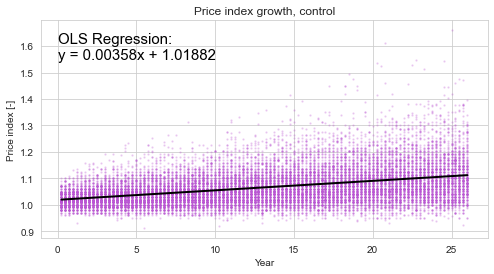

In [29]:
# Control dataset cleanup, price index
plotty = control_df.reset_index()
plotty['step'] = plotty['step'].astype(int) / 4  # convert from timesteps to year
sk_linreg = LinearRegression()  # set up linear regression
sk_linreg.fit(X=plotty['step'].to_numpy()[:, np.newaxis], y=plotty['h_value'].to_numpy())  # do data fitting, caveat with the newaxis thing (since X needs to receive >2d array
# get linear regression for house index pricing
sk_linreg_yp = sk_linreg.predict(plotty['step'].unique()[:, np.newaxis])
## Plotting for description
eq_linreg = f"OLS Regression: \ny = {round(sk_linreg.coef_[0],5)}x + {round(sk_linreg.intercept_, 5)}"
fig, ax = plt.subplots(figsize=(8,4))
plt.scatter(plotty['step'], plotty['h_value'], s=2, alpha=0.2, color='mediumorchid')
ax.text(0, 1.55, eq_linreg, color='black', fontsize=15)  # insert text
plt.plot(plotty['step'].unique(), sk_linreg_yp, linewidth=2, color='black')
ax.set_xlabel('Year')
ax.set_ylabel('Price index [-]')
ax.set_title("Price index growth, control")
plt.savefig("data_model_outputs/plots_stats/control_hv_linreg.jpeg", dpi=400)

# generate the control regression data for DID operations later
control_hv_reg = pd.Series(dict(zip(plotty['step'].unique(), sk_linreg_yp)))

In [30]:

for timing in select_2fs:
    # slice subset of all scenarios
    subset = all_scenarios_df.loc[all_scenarios_df['timings'].isin([timing]), :]
    # define all steps that are used to plot
    time_slice = range((timing[1] // STEPS_PER_YEAR) + time_range[0],
                       (timing[1] // STEPS_PER_YEAR) + time_range[1] + 1)

    # process transactions for transactions
    all_t = [pd.read_pickle(f'{save_dir}/{path}') for path in subset['T']]
    # all_t.append(control_df)
    scen_name = subset.index.str.split("_").str[1].tolist()  #.append('Control')  # scenario name
    all_t_df = pd.concat(all_t, keys=scen_name, names=['scenario']).reset_index()

    # conduct DID on the print_columns
    all_t_df['win_bid_d'] = all_t_df['win_bid'] - control_wb_line

    # all_t_df['h_value_dmean'] = all_t_df['h_value'] - all_t_df['step'].astype(int).map(control_hv_stats['mean'])
    # all_t_df['h_value_dmedian'] = all_t_df['h_value'] - all_t_df['step'].astype(int).map(control_hv_stats['median'])

    # Time conversion section
    # create another column for 5-year intervals
    all_t_df['year'] = (all_t_df['step'].astype(int) // 20 * 5).astype('category')
    # combine all transactions into a year
    all_t_df['step'] = (all_t_df['step'].astype(int) // 4).astype('category')
    all_t_df['h_value_d'] = all_t_df['h_value'] - all_t_df['step'].astype(int).map(control_hv_reg)

    all_t_df_mod = all_t_df[all_t_df['step'].isin(time_slice)].copy(deep=True)
    all_t_df_mod['timing_2f'] = timing[1] // STEPS_PER_YEAR
    # rename step to be counting from 2nd flood onset
    all_t_df_mod['step'] = all_t_df_mod['step'].astype(int) - (timing[1] // STEPS_PER_YEAR)
    all_t_extract_2f_list.append(all_t_df_mod)
    # t_group = all_t_df.groupby(["category", "step"])  # set up groupby object
    # # sort according to percentiles, based on winning bid
    # focus_col = 'win_bid'
    # t_describe_winbid = t_group[focus_col].describe(percentiles=[0.1, .5, 0.9])
    #
    # # get the skew of the year cross-section
    # t_describe_winbid['skew'] = t_group[focus_col].agg(stats.skew)
    # # t_describe_winbid['iqr_50'] = t_group[focus_col].agg(stats.iqr, **{})
    # t_describe_winbid['iqr_80'] = t_group[focus_col].agg(stats.iqr, **{'rng': (10, 90)})
    #
    # # test1 = t_group['h_value'].describe(percentiles=[.1, .25, .5, .75, .9])
    # focus_col = 'h_value'
    # t_describe_hvalue = t_group[focus_col].describe(percentiles=[.1, .5, .9])
    #
    # t_describe_hvalue['skew'] = t_group[focus_col].agg(stats.skew)
    # # t_describe_hvalue['iqr_50'] = t_group[focus_col].agg(stats.iqr, **{})
    # t_describe_hvalue['iqr_80'] = t_group[focus_col].agg(stats.iqr, **{'rng': (10, 90)})

    # look at transactions post-flood, for unflooded districts

    # slice for time steps, note that the times are in categorical, so a list is required

    # t_dhv_2f_df = t_describe_hvalue.copy(deep=True).reset_index()
    # extract categories
    # unflooded_categories = [cat for cat in t_dhv_2f_df['category'].astype('category').cat.categories if
    #                         "Unflooded" in cat]
    # flooded_categories = [cat for cat in t_dhv_2f_df['category'].astype('category').cat.categories if
    #                       "Flooded" in cat]
    # unflooded_categories.append('Control')
    # flooded_categories.append('Control')

    # for cats, target in [(flooded_categories, agg_p_post2F_flood_list),
    #                      (unflooded_categories, agg_p_post2F_noflood_list)]:
    #     # extract from describe df the relevant categories and timing
    #     t_dhv_2f_df_filtered = t_dhv_2f_df[
    #         (t_dhv_2f_df['category'].isin(cats)) & t_dhv_2f_df['step'].isin(time_slice)].copy(deep=True)
    #     t_dhv_2f_df_filtered['step'] = t_dhv_2f_df_filtered['step'].astype(int) - (
    #                 timing[1] // STEPS_PER_YEAR)  # recast steps into N years after flood event.
    #     t_dhv_2f_df_filtered['timing_2f'] = (timing[1] // STEPS_PER_YEAR)
    #     target.append(t_dhv_2f_df_filtered)  # append for concat later
    #
    # # REACTIVATE when done
    # t_dwb_2f_df = t_describe_winbid.copy(deep=True).reset_index()
    # # t_dwb_2f_df['category'] = t_dwb_2f_df['category'].str.split(',').str[0].astype('category')  # separate between flooded/unflooded
    # # unflooded_categories = [cat for cat in t_dwb_2f_df['category'].astype('category').cat.categories if "Unflooded" in cat]
    # # flooded_categories = [cat for cat in t_dwb_2f_df['category'].astype('category').cat.categories if "Flooded" in cat]
    #
    # for cats, target in [(flooded_categories, agg_t_post2F_flood_list),
    #                      (unflooded_categories, agg_t_post2F_noflood_list)]:
    #     t_dwb_2f_df_filtered = t_dwb_2f_df[
    #         (t_dwb_2f_df['category'].isin(cats)) & t_dwb_2f_df['step'].isin(time_slice)].copy(deep=True)
    #     t_dwb_2f_df_filtered['step'] = t_dwb_2f_df_filtered['step'].astype(int) - (timing[1] // STEPS_PER_YEAR)
    #     t_dwb_2f_df_filtered['timing_2f'] = (timing[1] // STEPS_PER_YEAR)
    #     target.append(t_dwb_2f_df_filtered)


        # append scenario type to the describe
        # save median, skew, mean
        # get average of medians

In [31]:
all_t_df.tail()
# control_hv_stats['mean']

,scenario,step,unique_id,district,win_bid,price_delta,category,h_value,win_bid_d,year,h_value_d
848936,v4b[park.1e6+park.1e4],26,HouseholdAgent_charlois_457,charlois,1.00,0.00,"Unflooded, safe",1.313583,-0.02,25,0.201566
848937,v4b[park.1e6+park.1e4],26,HouseholdAgent_charlois_89,charlois,1.00,0.00,"Unflooded, safe",1.182014,-0.02,25,0.069997
848938,v4b[park.1e6+park.1e4],26,HouseholdAgent_charlois_261,charlois,1.01,0.01,"Unflooded, safe",1.314715,-0.01,25,0.202699
848939,v4b[park.1e6+park.1e4],26,HouseholdAgent_charlois_561,charlois,1.02,0.02,"Unflooded, safe",1.181673,0.00,25,0.069657
848940,v4b[park.1e6+park.1e4],26,HouseholdAgent_charlois_3,charlois,1.00,0.00,"Unflooded, safe",1.070772,-0.02,25,-0.041245


In [32]:
# have step, can access the hv array

# Data collection

In [33]:
# rename items and prepare ordering for plotting later
yr_col_map = {'timing_2f': "Timing\nbetween\n1st & 2nd\nflood [yr]"}
yr_new_name = yr_col_map['timing_2f']
select_2fs_years_r = select_2fs_years[::-1]  # reversed order
col_order_noF = ['Close proximity 1', 'Close proximity 1+2', 'Close proximity 2', 'Safe']
col_order_yesF = ['1', '1+2', '2']  # watch out for mismatch


In [34]:
# extract raw transaction data for plotting graphs
all_t_extract_2f_df = pd.concat(all_t_extract_2f_list).reset_index()
all_t_extract_2f_df[['subcategory_1', 'subcategory_2']] = all_t_extract_2f_df['category'].str.split(", ", expand=True)
all_t_extract_2f_df['subcategory_2'] = all_t_extract_2f_df['subcategory_2'].str.capitalize()
all_t_extract_2f_df['subcategory_2'].fillna('Control', inplace=True)  # nan would be Control
all_t_extract_2f_df['subcategory_2'] = all_t_extract_2f_df['subcategory_2'].astype('category')
all_t_extract_2f_df['subcategory_1'] = all_t_extract_2f_df['subcategory_1'].astype('category')
all_t_extract_2f_df['category'] = all_t_extract_2f_df['category'].astype('category')
all_t_extract_2f_df.rename(columns=yr_col_map, inplace=True)

all_t_extract_2f_flooded = all_t_extract_2f_df[all_t_extract_2f_df['subcategory_1'].isin(['Flooded', 'Control'])]
all_t_extract_2f_unflooded = all_t_extract_2f_df[all_t_extract_2f_df['subcategory_1'].isin(['Unflooded', 'Control'])]

In [35]:

view = all_t_extract_2f_df.head(20)

In [36]:
all_t_extract_2f_flooded.subcategory_1.value_counts()

Flooded      980102
Unflooded         0
Name: subcategory_1, dtype: int64

In [37]:
# # concat and extract the post 2f list
# def concat_prep(input_list):  # convenience function
#     out = pd.concat(input_list)
#     out['category'] = out['category'].str.split(', ').str[1].str.capitalize().fillna(value='Control')
#     out['category'] = out['category'].astype('category')
#     out.rename(columns=yr_col_map, inplace=True)
#     # out.fillna(value={'category': 'Control'}, inplace=True)
#     return out
#
#
# agg_t_post2F_flood = concat_prep(agg_t_post2F_flood_list)
# agg_t_post2F_noflood = concat_prep(agg_t_post2F_noflood_list)
# agg_p_post2F_noflood = concat_prep(agg_p_post2F_noflood_list)
# agg_p_post2F_flood = concat_prep(agg_p_post2F_flood_list)



In [38]:
# plotting definitions


# Cmap definition

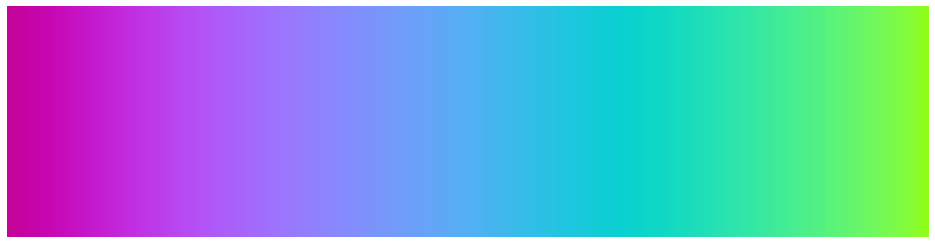

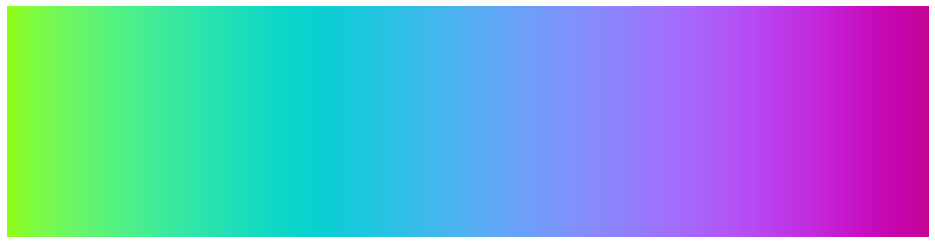

In [39]:
cmap_range = (0.25, 0.8)
cmap_t1 = cmasher.get_sub_cmap('cmr.torch', cmap_range[0], cmap_range[1])
cmap_t1r = cmasher.get_sub_cmap('cmr.torch_r', 1. - cmap_range[1], 1 - cmap_range[0])

cmap_range = (0, 0.8)
cmap_t2r = cmasher.get_sub_cmap('cmr.neon_r', 0., 0.8)
cmap_t2 = cmasher.get_sub_cmap('cmr.neon', 1. - cmap_range[1], 1. - cmap_range[0])
cmasher.view_cmap(cmap_t2)
cmasher.view_cmap(cmap_t2r)

# 2 floods:
## Winning bids

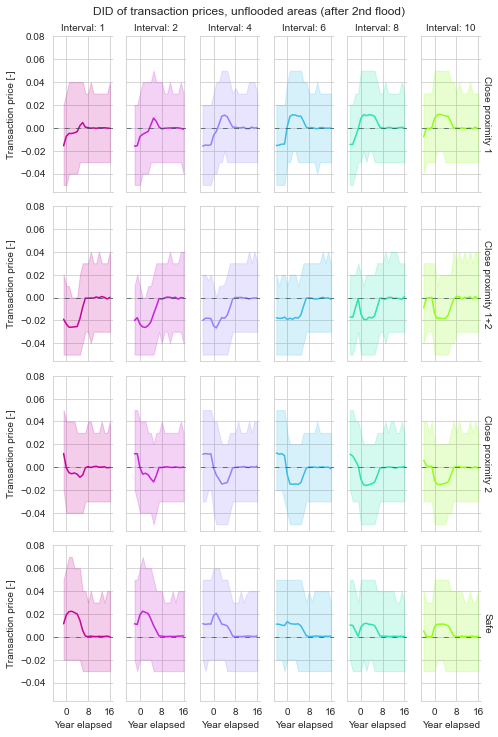

In [40]:
fg_wb_2nf = sns.relplot(data=all_t_extract_2f_unflooded,
                        kind='line', x='step', y='win_bid_d',
                        row='subcategory_2', col=yr_new_name,
                        hue=yr_new_name,
                        hue_order=select_2fs_years_r,
                        row_order=col_order_noF,
                        palette=cmap_t2, legend=False,
                        height=2.6, aspect=0.45, errorbar=('pi', 80), facet_kws={'margin_titles': True})
fg_wb_2nf.figure.suptitle("DID of transaction prices, unflooded areas (after 2nd flood)")
fg_wb_2nf.set_xlabels('Year elapsed')
fg_wb_2nf.set_ylabels('Transaction price [-]')
fg_wb_2nf.set_titles(template=None, col_template="Interval: {col_name}", row_template='{row_name}')
fg_wb_2nf.set(xticks=[0, time_range[1] // 2, time_range[1]], ylim=(None, 0.08))
fg_wb_2nf.refline(y=0., color='darkslategray', linestyle=(0, (7, 9)), linewidth=.7)
fg_wb_2nf.tight_layout()
fg_wb_2nf.savefig('data_model_outputs/plots_stats/211_wb_post2f_nf.jpg', dpi=400)


### Winning bids, flooded areas


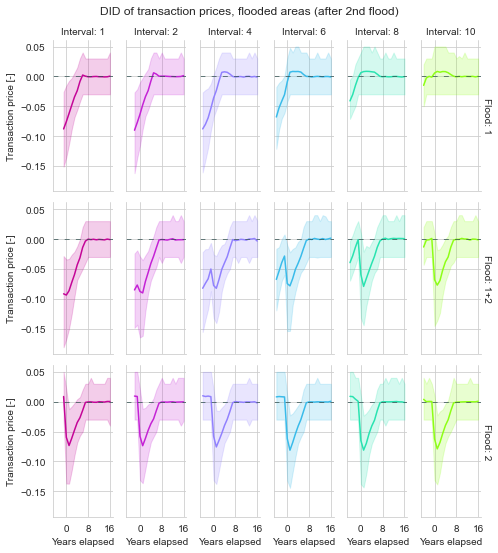

In [41]:
fg_wb_2yf = sns.relplot(data=all_t_extract_2f_flooded,
                        row='subcategory_2', col=yr_new_name, hue=yr_new_name,
                        palette=cmap_t2, height=2.6, aspect=0.45,
                        hue_order=select_2fs_years_r,
                        row_order=col_order_yesF, legend=False,
                        y='win_bid_d', x='step', kind='line', errorbar=('pi',80), facet_kws={'margin_titles': True})
fg_wb_2yf.figure.suptitle("DID of transaction prices, flooded areas (after 2nd flood)")
fg_wb_2yf.set_xlabels('Years elapsed')
fg_wb_2yf.set_ylabels('Transaction price [-]')
fg_wb_2yf.set_titles(template=None, col_template="Interval: {col_name}", row_template='Flood: {row_name}')
fg_wb_2yf.set(xticks=[0, time_range[1] // 2, time_range[1]])
# fg_wb_mean_2yf.set(ylim=(-0.05, 0.05))
fg_wb_2yf.refline(y=0., color='darkslategray', linestyle=(0, (7, 9)), linewidth=.7)
fg_wb_2yf.tight_layout()
fg_wb_2yf.savefig('data_model_outputs/plots_stats/221_wb_2yf.jpg', dpi=400)

In [42]:
fg_wb_2yf.set(ylim=(-0.05, 0.05), yticks=np.arange(-5, 5, 1) / 100)
fg_wb_2yf.savefig('data_model_outputs/plots_stats/221a_wb_mean_2yf.jpg', dpi=400)

In [43]:
# fg_wb_skew_2yf = sns.relplot(data=agg_t_post2F_flood,
#                              col='category', hue=yr_new_name, size='step',
#                              palette=cmap_t2, height=5.5, aspect=0.35,
#                              hue_order=select_2fs_years_r,
#                              col_order=col_order_yesF,
#                              y='skew', x='std', kind='scatter')
# fg_wb_skew_2yf.figure.suptitle("Skew vs SD of winning bids, flooded areas, after 2nd flood")
# fg_wb_skew_2yf.set_xlabels('SD [-]')
# fg_wb_skew_2yf.set_ylabels('Skew [-]')
# fg_wb_skew_2yf.set_titles(template=None, col_template="Flood: {col_name}")
# fg_wb_skew_2yf.set(xlim=(0., 0.1))
# fg_wb_skew_2yf.tight_layout()
# fg_wb_skew_2yf.savefig('data_model_outputs/plots_stats/223_wb_skew_2yf.jpg', dpi=600)


## Home values

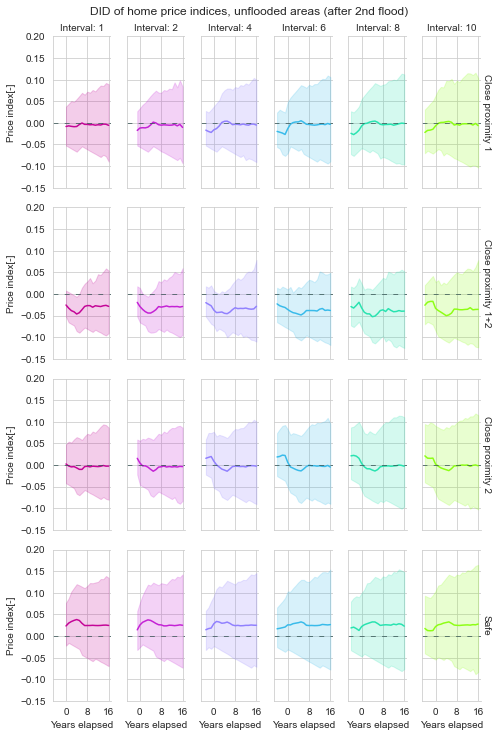

In [44]:
fg_hv_2nF = sns.relplot(data=all_t_extract_2f_unflooded,
                        kind='line', x='step', y='h_value_d',
                        row='subcategory_2', col=yr_new_name, hue=yr_new_name,
                        hue_order=select_2fs_years_r,
                        row_order=col_order_noF,
                        palette=cmap_t2, legend=False,
                        height=2.6, aspect=.45, errorbar=('pi', 80), facet_kws={'margin_titles': True})

fg_hv_2nF.figure.suptitle("DID of home price indices, unflooded areas (after 2nd flood)")
fg_hv_2nF.set_xlabels('Years elapsed')
fg_hv_2nF.set_ylabels('Price index[-]')
fg_hv_2nF.set_titles(template=None, col_template="Interval: {col_name}", row_template='{row_name}')
fg_hv_2nF.set(xticks=[0, time_range[1] // 2, time_range[1]], yticks=np.arange(-15, 21, 5) / 100)
fg_hv_2nF.refline(y=0., color='darkslategray', linestyle=(0, (7, 9)), linewidth=.7)
fg_hv_2nF.tight_layout()
fg_hv_2nF.savefig('data_model_outputs/plots_stats/231_hv_mean_2nf.jpg', dpi=400)

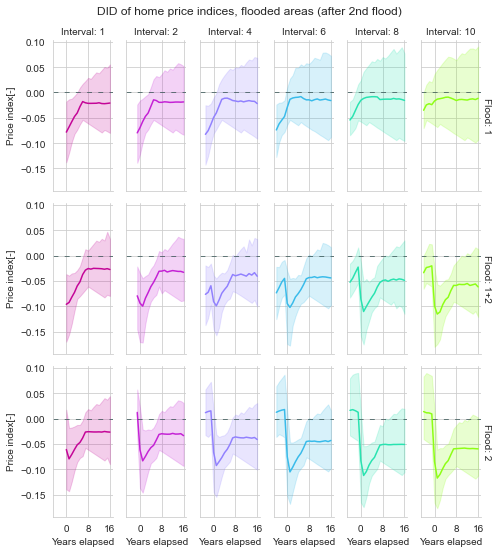

In [45]:

fg_hv_2yF = sns.relplot(data=all_t_extract_2f_flooded,
                        kind='line', x='step', y='h_value_d',
                        row='subcategory_2', col=yr_new_name, hue=yr_new_name,
                        hue_order=select_2fs_years_r,
                        row_order=col_order_yesF,
                        palette=cmap_t2, legend=False,
                        height=2.6, aspect=.45, errorbar=('pi', 80), facet_kws={'margin_titles': True})

fg_hv_2yF.figure.suptitle("DID of home price indices, flooded areas (after 2nd flood)")
fg_hv_2yF.set_xlabels('Years elapsed')
fg_hv_2yF.set_ylabels('Price index[-]')
fg_hv_2yF.set_titles(template=None, col_template="Interval: {col_name}", row_template='Flood: {row_name}')
fg_hv_2yF.set(xticks=[0, time_range[1] // 2, time_range[1]], yticks=np.arange(-15, 11, 5) / 100)
fg_hv_2yF.refline(y=0., color='darkslategray', linestyle=(0, (7, 9)), linewidth=.7)
fg_hv_2yF.tight_layout()
fg_hv_2yF.savefig('data_model_outputs/plots_stats/241_hv_2yf.jpg', dpi=400)

# 1-flood plots

In [46]:
timing_1f = timing_categories[1]
scen_prefix = f"{output_addition}["  # for more readable legend labels
scen_suffix = f']'

subset_1f = all_scenarios_df.loc[all_scenarios_df['timings'].isin([timing_1f]), :]
# scen_names_1f = subset_1f.index.str.split("_").str[1]
scen_names_1f = [event_tup[0] for event_tup in subset_1f.events]

all_t_1f = [pd.read_pickle(f'{save_dir}/{path}') for path in subset_1f['T']]
all_t_1f_df = pd.concat(all_t_1f, keys=scen_names_1f, names=['Scenario']).reset_index()
# convert win_bid to DID
all_t_1f_df['win_bid_d'] = all_t_1f_df['win_bid'] - control_wb_line


all_t_1f_df['year'] = (all_t_1f_df['step'].astype(int) // 20 * 5).astype('category')
# combine all transactions into a year
all_t_1f_df['step'] = (all_t_1f_df['step'].astype(int) // 4).astype('category')
# convert h_value to DID
all_t_1f_df['h_value_d'] = all_t_1f_df['h_value'] - all_t_1f_df['step'].astype(int).map(control_hv_reg)


In [47]:
# modification for skew  v SD plots
# def duplicate_control(input_df):
#     # duplicate the control entries into flooded and unflooded so the skew SD diagrams work for the single flood plots
#     control = input_df[input_df['Scenario'] == 'Control']
#     # t_dhv_1f_control = t_dhv_1f_df[t_dhv_1f_df['Scenario'] == "Control"]
#     control_nf, control_yf = control.copy(deep=True), control.copy(deep=True)
#     control_yf['category'] = 'Flooded'
#     control_nf['category'] = 'Unflooded'
#     out_cmod = input_df[input_df['Scenario'] != 'Control'].copy(deep=True)
#     out_cmod = pd.concat([out_cmod, control_yf, control_nf], ignore_index=True)
#     return out_cmod
#
#
# t_dwb_1f_cmod = duplicate_control(t_dwb_1f_df)
# t_dhv_1f_cmod = duplicate_control(t_dhv_1f_df)



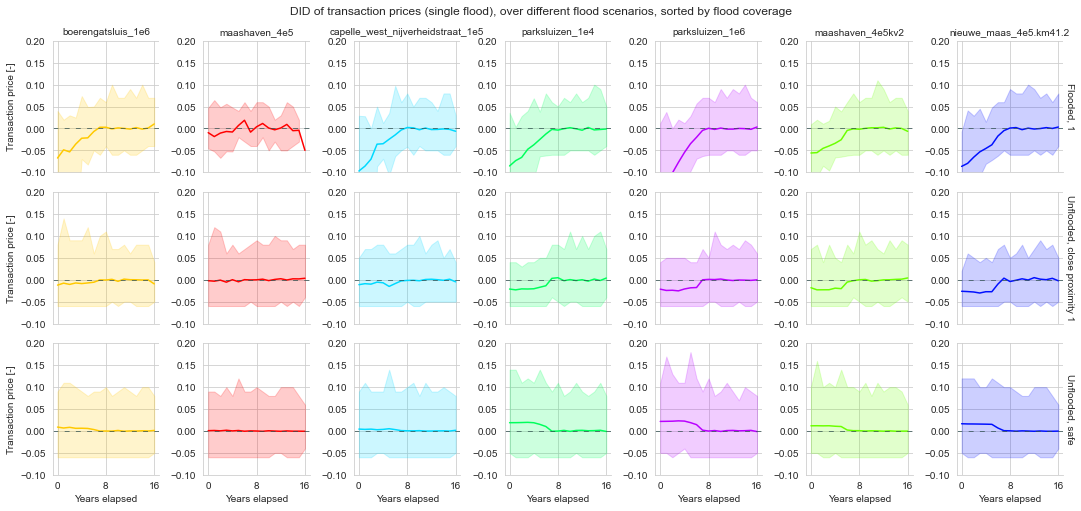

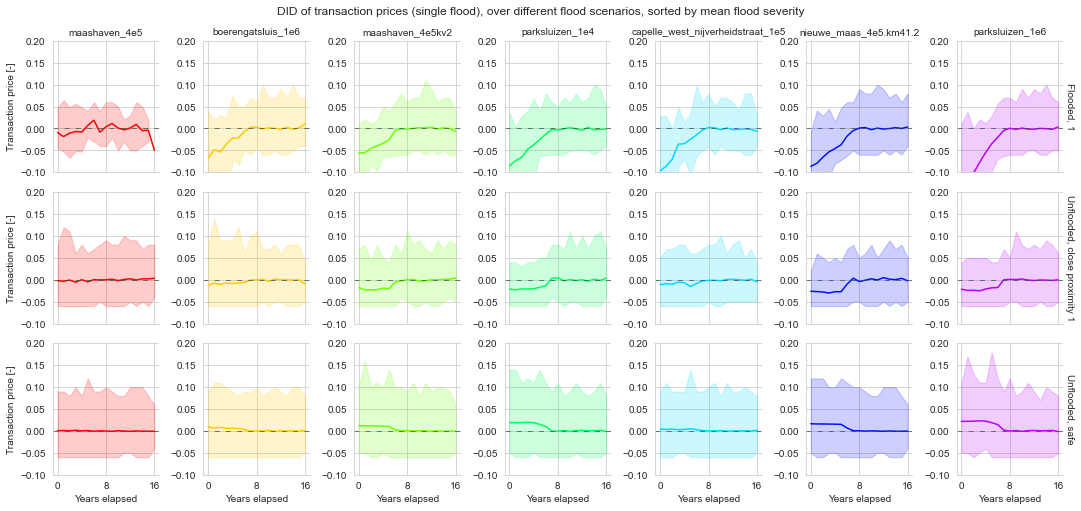

In [48]:
for mode in ['fld_coverage','fld_severity']:
    if mode == 'fld_coverage':
        col_order = scen_coverage
        sort = "flood coverage"
    elif mode == 'fld_severity':
        col_order = scen_severity
        sort = "mean flood severity"
    else:
        raise ValueError(f'mode {mode} invalid')

    colors = cmasher.take_cmap_colors('hsv', len(all_t_1f_df.Scenario.unique()), cmap_range=(0,.8) )
    fg_wb_1f = sns.relplot(data=all_t_1f_df,
                           row='category', col='Scenario', hue='Scenario', palette=colors, col_order=col_order,
                           hue_order=scen_severity,
                           y='win_bid_d', x='step', kind='line', errorbar=('pi',100), facet_kws={'sharey': False, 'margin_titles': True}, height=2.4, aspect=0.9, legend=False)
    fg_wb_1f.figure.suptitle(f"DID of transaction prices (single flood), over different flood scenarios, sorted by {sort}")
    fg_wb_1f.set_xlabels('Years elapsed')
    fg_wb_1f.set_ylabels('Transaction price [-]')
    fg_wb_1f.set_titles(template=None, col_template="{col_name}", row_template='{row_name}')
    # fg_wb_mean_1F.add_legend()
    # fg_wb_mean_1F.set(xticks=[time_range[0],0,4,time_range[1]])
    fg_wb_1f.set(xticks=[0, time_range[-1] // 2, time_range[-1]])
    fg_wb_1f.refline(y=0., color='darkslategray', linestyle=(0, (7, 9)), linewidth=.7)
    for row in range(fg_wb_1f.axes.shape[0]):  # access row
        # if row == 0:
        #     ylim = (-.2, 0.1)
        #     ticks = np.arange(-10, 21, 10) / 100
        # else:
        ylim = (-0.1, 0.2)
        ticks = np.arange(-10, 21, 5) /100
        for col in range(fg_wb_1f.axes.shape[1]): # access col
            fg_wb_1f.axes[row, col].set_ylim(ylim)
            fg_wb_1f.axes[row, col].set_yticks(ticks)

    fg_wb_1f.tight_layout()
    fg_wb_1f.savefig(f'data_model_outputs/plots_stats/111_wb_1f_{mode}.jpg', dpi=400)
    # probably need to separate and zoom into the graphs for unflooded
    # would be nice to access the row level and modify the sharey

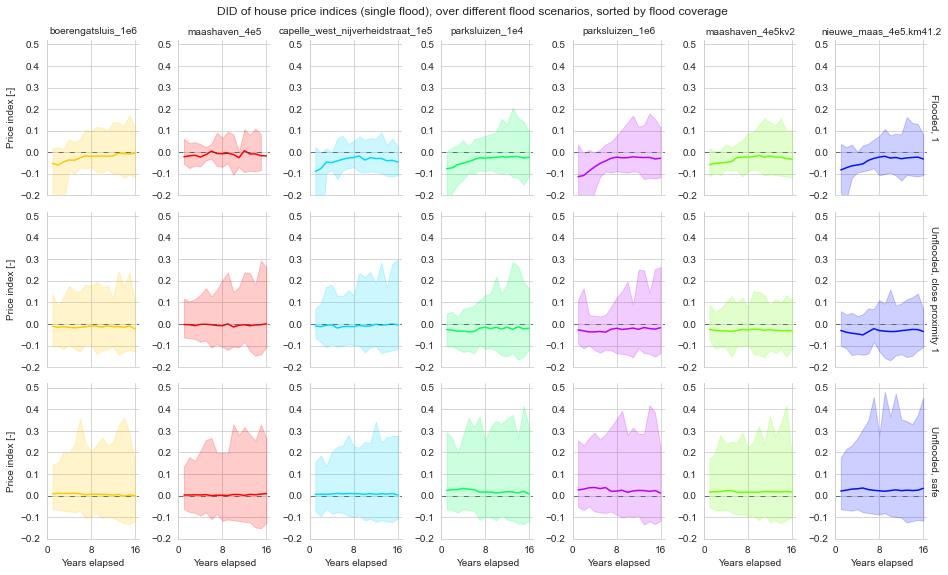

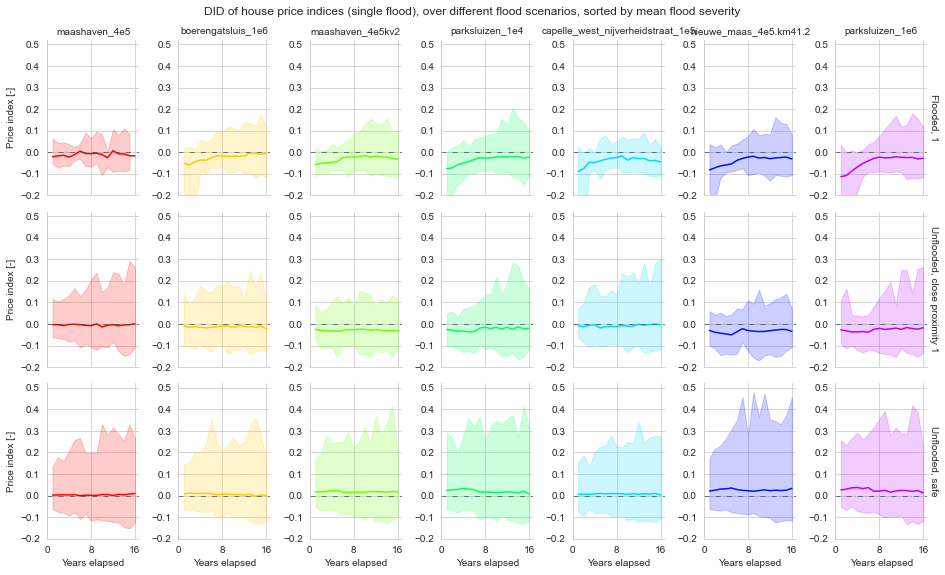

In [49]:
for mode in ['fld_coverage','fld_severity']:
    if mode == 'fld_coverage':
        col_order = scen_coverage
        sort = "flood coverage"
    elif mode == 'fld_severity':
        col_order = scen_severity
        sort = "mean flood severity"
    else:
        raise ValueError(f'mode {mode} invalid')

    colors = cmasher.take_cmap_colors('hsv', len(all_t_1f_df.Scenario.unique()), cmap_range=(0,.8) )
    fg_hv_1F = sns.relplot(data=all_t_1f_df,
                                row='category', col='Scenario', hue='Scenario', palette=colors, col_order=col_order,
                                hue_order=scen_severity,
                                y='h_value_d', x='step', kind='line', errorbar=('pi',100), facet_kws={'sharey': False, 'margin_titles': True}, height=2.7, aspect=0.7, legend=False)
    fg_hv_1F.figure.suptitle(f"DID of house price indices (single flood), over different flood scenarios, sorted by {sort}")
    fg_hv_1F.set_xlabels('Years elapsed')
    fg_hv_1F.set_ylabels('Price index [-]')
    fg_hv_1F.set_titles(template=None, col_template="{col_name}", row_template='{row_name}')
    # fg_hv_1F.add_legend()
    # fg_hv_1F.set(xticks=[time_range[0],0,4,time_range[1]])
    fg_hv_1F.set(xticks=[0, time_range[-1]//2, time_range[-1]])
    fg_hv_1F.refline(y=0., color='darkslategray', linestyle=(0, (7,9)), linewidth=.7)
    for row in range(fg_hv_1F.axes.shape[0]):  # access row
        # if row == 0:
        #     ylim = (-.2, 0,22)
        #     ticks = np.arange(-20, 21, 10) / 100
        # else:
        ylim = (-0.2, 0.52)
        ticks = np.arange(-20, 51, 10) /100
        for col in range(fg_hv_1F.axes.shape[1]): # access col
            fg_hv_1F.axes[row,col].set_ylim(ylim)
            fg_hv_1F.axes[row, col].set_yticks(ticks)

    fg_hv_1F.tight_layout()
    fg_hv_1F.savefig(f'data_model_outputs/plots_stats/121_hv_1f_{mode}.jpg', dpi=400)

# Code Boneyard

In [50]:
# values = ['90%', '10%']
# melty = pd.melt(agg_p_post2F_noflood,
#                 id_vars=['category', yr_new_name, 'step'],
#                 value_vars=values)
# melty.rename(columns={'variable': 'Percentile'}, inplace=True)
# fg_hv_range_2nF = sns.relplot(data=melty,
#                               col='category', hue=yr_new_name, style='Percentile',
#                               palette=cmap_t2r, height=5.5, aspect=0.35,
#                               hue_order=select_2fs_years_r,
#                               col_order=col_order_noF,
#                               y='value', x='step', kind='line')
# fg_hv_range_2nF.figure.suptitle("Interdecile range of price indices, unflooded areas, after 2nd flood")
# fg_hv_range_2nF.set_xlabels('Years elapsed')
# fg_hv_range_2nF.set_ylabels('Winning bid [-]')
# fg_hv_range_2nF.set_titles(template=None, col_template="{col_name}")
# fg_hv_range_2nF.set(xticks=[time_range[0], 0, 4, time_range[1]])
# fg_hv_range_2nF.tight_layout()
# fg_hv_range_2nF.savefig('data_model_outputs/plots_stats/232_hv_range_2nf.jpg', dpi=600)
# fg_hv_skew_2nF = sns.relplot(data=agg_p_post2F_noflood,
#                              col='category', hue=yr_new_name, size='step',
#                              palette=cmap_t2r, height=5.5, aspect=0.35,
#                              hue_order=select_2fs_years_r,
#                              col_order=col_order_noF,
#                              y='skew', x='std', kind='scatter')
# fg_hv_skew_2nF.figure.suptitle("Skew vs. SD of home values, unflooded areas, after 2nd flood")
# fg_hv_skew_2nF.set_xlabels('SD [-]')
# fg_hv_skew_2nF.set_ylabels('Skew [-]')
# fg_hv_skew_2nF.set_titles(template=None, col_template="{col_name}")
# fg_hv_skew_2nF.tight_layout()
# fg_hv_mean_2yF = sns.relplot(data=all_t_extract_2f_flooded,
#                              kind='line', x='step', y='h_value',
#                              col='subcategory_2', hue=yr_new_name,
#                              hue_order=select_2fs_years_r,
#                              col_order=col_order_yesF,
#                              palette=cmap_t2r, legend="auto",
#                              height=5.5, aspect=.35, errorbar=None)
# fg_hv_mean_2yF.figure.suptitle("Mean of house values, flooded areas, after 2nd flood")
# fg_hv_mean_2yF.set_xlabels('Years elapsed')
# fg_hv_mean_2yF.set_ylabels('Winning bid [-]')
# fg_hv_mean_2yF.set_titles(template=None, col_template="Flood: {col_name}")
# fg_hv_mean_2yF.set(xticks=[time_range[0], 0, 4, time_range[1]])
# fg_hv_mean_2yF.tight_layout()
# values = ['90%', '10%']
# melty = pd.melt(agg_p_post2F_flood,
#                 id_vars=['category', yr_new_name, 'step'],
#                 value_vars=values)
# melty.rename(columns={'variable': 'Percentile'}, inplace=True)
# fg_hv_range_2yF = sns.relplot(data=melty,
#                               col='category', hue=yr_new_name, style='Percentile',
#                               palette=cmap_t2r, height=5.5, aspect=0.35,
#                               hue_order=select_2fs_years_r,
#                               y='value', x='step', kind='line')
# fg_hv_range_2yF.figure.suptitle("Interdecile range of home values, flooded areas, after 2nd flood")
# fg_hv_range_2yF.set_xlabels('Years elapsed')
# fg_hv_range_2yF.set_ylabels('Winning bid [-]')
# fg_hv_range_2yF.set_titles(template=None, col_template="Flood:{col_name}")
# fg_hv_range_2yF.set(xticks=[time_range[0], 0, 4, time_range[1]])
# fg_hv_range_2yF.tight_layout()
# fg_hv_skew_2yF = sns.relplot(data=agg_p_post2F_flood,
#                              col='category', hue=yr_new_name, size='step',
#                              palette=cmap_t2r, height=5.5, aspect=0.35,
#                              hue_order=select_2fs_years_r,
#                              y='skew', x='std', kind='scatter')
# fg_hv_skew_2yF.figure.suptitle("Skew vs. SD of winning bids, flooded areas, after 2nd floob
# fg_hv_skew_2yF.set_xlabels('SD [-]')
# fg_hv_skew_2yF.set_ylabels('Skew [-]')
# fg_hv_skew_2yF.set_titles(template=None, col_template="Flood: {col_name}")
# fg_hv_skew_2yF.set(xlim=(0., 0.15))
# fg_hv_skew_2yF.tight_layout()
# fg_hv_skew_2yF.savefig('data_model_outputs/plots_stats/243_hv_skew_2yf.jpg', dpi=600)


In [51]:
# fg_wb_mean_2nf_kde = sns.FacetGrid(all_t_extract_2f_unflooded, col='subcategory_2', hue=yr_new_name,
#                                    legend_out=True, height=2.7, aspect=0.8, col_order=col_order_noF)
# fg_wb_mean_2nf_kde.map_dataframe(sns.kdeplot, x='step',y='win_bid', fill=True)
# sns.kdeplot(data=all_t_extract_2f_unflooded, x='step',y='win_bid', hue=yr_new_name, fill=True)
# plot the bounds of upper bound and lower bound. currently uses the deciles
# values = ['max','min']
# values = ['90%', '10%']
# melty = pd.melt(agg_t_post2F_noflood,
#                 id_vars=['category', yr_new_name, 'step'],
#                 value_vars=values)
# melty.rename(columns={'variable': 'Percentile'}, inplace=True)
# fg_wb_range_2nf = sns.relplot(data=melty,
#                               col='category', hue=yr_new_name, style='Percentile',
#                               palette=cmap_t2, height=5.5, aspect=0.35,
#                               col_order=col_order_noF,
#                               hue_order=select_2fs_years_r,
#                               y='value', x='step', kind='line')
# fg_wb_range_2nf.figure.suptitle("Interdecile range of winning bids, unflooded areas, after 2nd flood")
# fg_wb_range_2nf.set_xlabels('Years elapsed')
# fg_wb_range_2nf.set_ylabels('Winning bid [-]')
# fg_wb_range_2nf.set_titles(template=None, col_template="{col_name}")
# # fg_wb_range.add_legend()
# fg_wb_range_2nf.set(xticks=[time_range[0], 0, 4, time_range[1]])
# fg_wb_range_2nf.tight_layout()
# plot skew
# fg_wb_skew_2nf = sns.relplot(data=agg_t_post2F_noflood,
#                              col='category', hue=yr_new_name, size='step',
#                              palette=cmap_t2, height=5.5, aspect=0.35,
#                              col_order=col_order_noF,
#                              hue_order=select_2fs_years_r,
#                              y='skew', x='std', kind='scatter')
# fg_wb_skew_2nf.figure.suptitle("Skew vs. SD of winning bids, unflooded areas, after 2nd flood")
# fg_wb_skew_2nf.set_xlabels('SD [-]')
# fg_wb_skew_2nf.set_ylabels('Skew [-]')
# fg_wb_skew_2nf.set_titles(template=None, col_template="{col_name}")
# fg_wb_skew_2nf.tight_layout()

In [52]:
# create another column for 5-year intervals
# all_t_1f_df['Scenario'] = all_t_1f_df['Scenario'].str.removeprefix(scen_prefix).str.removesuffix(scen_suffix) #.replace({'': 'Control'}).astype('category')
# all_t_1f_df['Scenario_full'] = all_t_1f_df['Scenario'].map(scen_shortnames)
# all_t_1f_df['category'] = all_t_1f_df['category'].str.split(', ').str[0]  # choose only the
# first part of the category.
# fix the control information
# all_t_1f_df.loc[all_t_1f_df['Scenario'] == 'Control', 'category'] = 'Control'
# all_t_1f_df = all_t_1f_df.loc[all_t_1f_df['step'].isin(range(17)), :]
# all_t_1f_df['step'] = all_t_1f_df['step'].cat.remove_unused_categories()

# t_group_1f = all_t_1f_df.groupby(["category", "Scenario", 'step'])  # set up groupby object
# focus_col = 'win_bid'
# t_describe_winbid_1f = t_group_1f[focus_col].describe(percentiles=[0.1, .5, 0.9])
# t_describe_winbid_1f['skew'] = t_group_1f[focus_col].agg(stats.skew)
# t_dwb_1f_df = t_describe_winbid_1f.reset_index()
#
# focus_col = 'h_value'
# t_describe_hvalue_1f = t_group_1f[focus_col].describe(percentiles=[0.1, .5, .9])
# t_describe_hvalue_1f['skew'] = t_group_1f[focus_col].agg(stats.skew)
# t_describe_hvalue_1f['iqr_80'] = t_group_1f[focus_col].agg(stats.iqr, **{'rng': (10, 90)})
# t_dhv_1f_df = t_describe_hvalue_1f.reset_index()

In [53]:
# plot the bounds of upper bound and lower bound. currently uses the deciles
# values = ['max','min']
# values = ['90%', '10%']
# melty = pd.melt(agg_t_post2F_flood,
#                 id_vars=['category', yr_new_name, 'step'],
#                 value_vars=values)
# melty.rename(columns={'variable': 'Percentile'}, inplace=True)
# melty['Percentile'] = melty['Percentile'].str.replace("%", "th")
# fg_wb_range_2yf = sns.relplot(data=melty,
#                               col='category', hue=yr_new_name, style='Percentile',
#                               col_order=col_order_yesF,
#                               palette=cmap_t2, height=4.5, aspect=0.4,
#                               hue_order=select_2fs_years_r,
#                               y='value', x='step', kind='line', facet_kws={'margin_titles': True})
#
# fg_wb_range_2yf.figure.suptitle("Interdecile range of winning bids, flooded areas, after 2nd flood")
# fg_wb_range_2yf.set_xlabels('Years elapsed')
# fg_wb_range_2yf.set_ylabels('Winning bid [-]')
# fg_wb_range_2yf.set_titles(template=None, col_template="Flood: {col_name}", row_template="{row_name} percentile")
# fg_wb_range_2yf.set(xticks=[time_range[0], 0, 4, time_range[1]])
# fg_wb_range_2yf.tight_layout()
# fg_wb_range_2yf.savefig('data_model_outputs/plots_stats/222_wb_range_2yf.jpg', dpi=600)

In [54]:
# fg_wb_mean_1F_hl_nf = sns.relplot(data=all_t_1f_df,
#                                   col='category', hue='Scenario', palette='tab10',
#                                   col_order=['Control', 'Unflooded'],
#                                   y='win_bid', x='step', kind='line', errorbar=None, facet_kws={'sharey': True},
#                                   height=5.5, aspect=0.7)
# fg_wb_mean_1F_hl_nf.figure.suptitle("Mean of winning bids after 1st flood, for unflooded areas (emphasis unflooded)")
# fg_wb_mean_1F_hl_nf.set_xlabels('Years elapsed')
# fg_wb_mean_1F_hl_nf.set_ylabels('Winning bid [-]')
# fg_wb_mean_1F_hl_nf.set_titles(template=None, col_template="{col_name}")
# # fg_wb_mean_1F_hl_nf.add_legend()
# # fg_wb_mean_1F_hl_nf.set(xticks=[time_range[0],0,4,time_range[1]])
# fg_wb_mean_1F_hl_nf.set(xticks=[0, 8, 16])
# fg_wb_mean_1F_hl_nf.tight_layout()


In [55]:
# fg_wb_mean_1F_hl_yf = sns.relplot(data=all_t_1f_df,
#                                   col='category', hue='Scenario', palette='tab10',
#                                   col_order=['Control', 'Flooded'],
#                                   y='win_bid', x='step', kind='line', errorbar=None, facet_kws={'sharey': True},
#                                   height=4.5, aspect=0.7)
# fg_wb_mean_1F_hl_yf.figure.suptitle("Mean of winning bids after 1st flood, for unflooded areas (emphasis flooded)")
# fg_wb_mean_1F_hl_yf.set_xlabels('Years elapsed')
# fg_wb_mean_1F_hl_yf.set_ylabels('Winning bid [-]')
# fg_wb_mean_1F_hl_yf.set_titles(template=None, col_template="{col_name}")
# fg_wb_mean_1F_hl_yf.set(xticks=[0, 12], xlim=(0, 12), ylim=(0.96, 1.04))
# fg_wb_mean_1F_hl_yf.tight_layout()
# fg_wb_mean_1F_hl_yf.savefig('data_model_outputs/plots_stats/111b_wb_mean_1f.jpg', dpi=600)

In [56]:
# values = ['90%', '10%']
# melty = pd.melt(t_dwb_1f_df,
#                 id_vars=['category', 'Scenario', 'step'],
#                 value_vars=values)
# melty.rename(columns={'variable': 'Percentile'}, inplace=True)
# melty['Percentile'] = melty['Percentile'].str.replace("%", "th")
# fg_wb_range_1F = sns.relplot(data=melty, palette='tab10', style='Percentile',
#                              col='category', hue='Scenario',
#                              height=4, aspect=0.5,
#                              y='value', x='step', kind='line', facet_kws={'margin_titles': True})
# fg_wb_range_1F.figure.suptitle("Interdecile range of winning bids after flood (overview)")
# fg_wb_range_1F.set_xlabels('Years elapsed')
# fg_wb_range_1F.set_ylabels('Winning bid [-]')
# fg_wb_range_1F.set_titles(template=None, col_template="{col_name}", row_template="{row_name} percentile")
# # fg_wb_range_1F.add_legend()
# fg_wb_range_1F.set(xticks=[0, 8, 16], ylim=(0.95, 1.09))
# fg_wb_range_1F.tight_layout()
# # titling, better colouring,
# fg_wb_range_1F.savefig('data_model_outputs/plots_stats/112_wb_range_1f.jpg', dpi=600)


In [57]:
# values = ['90%', '10%']
# melty = pd.melt(t_dwb_1f_df,
#                 id_vars=['category', 'Scenario', 'step'],
#                 value_vars=values)
# melty.rename(columns={'variable': 'Percentile'}, inplace=True)
# melty['Percentile'] = melty['Percentile'].str.replace("%", "th")
# fg_wb_range_1F_hl_nf = sns.relplot(data=melty, palette='tab10', style='Percentile',
#                                    col='category', hue='Scenario',
#                                    col_order=['Control', 'Unflooded'],
#                                    height=4.5, aspect=0.6,
#                                    y='value', x='step', kind='line', facet_kws={'margin_titles': True})
# fg_wb_range_1F_hl_nf.figure.suptitle("Interdecile range of winning bids after flood (emphasis unflooded)")
# fg_wb_range_1F_hl_nf.set_xlabels('Years elapsed')
# fg_wb_range_1F_hl_nf.set_ylabels('Winning bid [-]')
# fg_wb_range_1F_hl_nf.set_titles(template=None, col_template="{col_name}", row_template="{row_name} percentile")
# # fg_wb_range_1F_hl_nf.add_legend()
# fg_wb_range_1F_hl_nf.set(xticks=[0, 16])
# fg_wb_range_1F_hl_nf.tight_layout()
# # titling, better colouring,
# fg_wb_range_1F_hl_nf.savefig('data_model_outputs/plots_stats/112a_wb_range_1f.jpg', dpi=600)


In [58]:
# fg_wb_range_1F_hl_yf = sns.relplot(data=melty, palette='tab10', style='Percentile',
#                                    col='category', hue='Scenario',
#                                    col_order=['Control', 'Flooded'],
#                                    height=4, aspect=0.6,
#                                    y='value', x='step', kind='line', facet_kws={'margin_titles': True})
# fg_wb_range_1F_hl_yf.figure.suptitle("Interdecile range of winning bids after flood (emphasis flooded)")
# fg_wb_range_1F_hl_yf.set_xlabels('Years elapsed')
# fg_wb_range_1F_hl_yf.set_ylabels('Winning bid [-]')
# fg_wb_range_1F_hl_yf.set_titles(template=None, col_template="{col_name}", row_template="{row_name} percentile")
# # fg_wb_range_1F_hl_yf.add_legend()
# fg_wb_range_1F_hl_yf.set(xticks=[0, 16], ylim=(0.92, 1.18))
# fg_wb_range_1F_hl_yf.tight_layout()
# fg_wb_range_1F_hl_yf.savefig('data_model_outputs/plots_stats/112b_wb_range_1f.jpg', dpi=600)

In [59]:
# fg_wb_skew_1F = sns.relplot(data=t_dwb_1f_cmod,
#                             col='Scenario', row='category', hue='Scenario', size='step',
#                             height=2.75, aspect=0.4, palette='tab10', sizes=(80, 10),
#                             y='skew', x='std', kind='scatter', facet_kws={'margin_titles': True})
# fg_wb_skew_1F.figure.suptitle("Skew vs SD of winning bids after flood")
# fg_wb_skew_1F.set_xlabels('SD [-]')
# fg_wb_skew_1F.set_ylabels('Skew [-]')
# fg_wb_skew_1F.set_titles(template=None, col_template="{col_name}", row_template='{row_name}')
# fg_wb_skew_1F.tight_layout()
# fg_wb_skew_1F.set(xlim=(0.01, 0.04), xticks=[0.01, 0.025, 0.04])
# fg_wb_skew_1F.savefig('data_model_outputs/plots_stats/113_wb_skew_1f.jpg', dpi=600)

# maybe plot with severity as an extra row?

In [60]:
# fg_hv_mean_1F = sns.relplot(data=all_t_1f_df,
#                             col='category', hue='Scenario', palette='tab10',
#                             y='h_value', x='step', kind='line', errorbar=None, facet_kws={'sharey': True}, height=5.5,
#                             aspect=0.55)
# fg_hv_mean_1F.figure.suptitle("Mean of price indices after flood, for single flood scenarios")
# fg_hv_mean_1F.set_xlabels('Years elapsed')
# fg_hv_mean_1F.set_ylabels('Price Index[-]')
# fg_hv_mean_1F.set_titles(template=None, col_template="{col_name}")
# # fg_hv_mean_1F.add_legend()
# # fg_hv_mean_1F.set(xticks=[time_range[0],0,4,time_range[1]])
# fg_hv_mean_1F.set(xticks=[0, 8, 16], ylim=(0.98, 1.12))
# fg_hv_mean_1F.tight_layout()
# fg_hv_mean_1F.savefig('data_model_outputs/plots_stats/121_hv_mean_1f.jpg', dpi=600)


In [61]:
# rename classes to fit the scenario names given at the start
# values = ['90%', '10%']
# melty = pd.melt(t_dhv_1f_df,
#                 id_vars=['category', 'Scenario', 'step'],
#                 value_vars=values)
# melty.rename(columns={'variable': 'Percentile'}, inplace=True)
# melty['Percentile'] = melty['Percentile'].str.replace("%", "th")
# fg_hv_range_1F = sns.relplot(data=melty, palette='tab10', style='Percentile',
#                              col='category', hue='Scenario',
#                              height=4.5, aspect=0.6,
#                              y='value', x='step', kind='line', facet_kws={'margin_titles': True, 'sharey': True})
# fg_hv_range_1F.figure.suptitle("Interdecile range of price indices, after flood (overview)")
# fg_hv_range_1F.set_xlabels('Years elapsed')
# fg_hv_range_1F.set_ylabels('Price index[-]')
# fg_hv_range_1F.set_titles(template=None, col_template="{col_name}", row_template="{row_name} percentile")
# # fg_hv_range_1F.add_legend()
# fg_hv_range_1F.set(xticks=[0, 8, 16], ylim=(0.9, 1.25))
# fg_hv_range_1F.tight_layout()
# fg_hv_range_1F.savefig('data_model_outputs/plots_stats/122_hv_range_1f.jpg', dpi=600)
#
# # titling, better colouring,

In [62]:
# values = ['90%', '10%']
# melty = pd.melt(t_dhv_1f_df,
#                 id_vars=['category', 'Scenario', 'step'],
#                 value_vars=values)
# melty.rename(columns={'variable': 'Percentile'}, inplace=True)
# melty['Percentile'] = melty['Percentile'].str.replace("%", "th")
# fg_hv_range_1F_hl_nf = sns.relplot(data=melty, palette='tab10', style='Percentile',
#                                    col='category', hue='Scenario',
#                                    height=5.5, aspect=0.5, col_order=['Control', 'Unflooded'],
#                                    y='value', x='step', kind='line', facet_kws={'margin_titles': True, 'sharey': True})
# fg_hv_range_1F_hl_nf.figure.suptitle("Interdecile range of price indices after flood (emphasis unflooded)")
# fg_hv_range_1F_hl_nf.set_xlabels('Years elapsed')
# fg_hv_range_1F_hl_nf.set_ylabels('Price index[-]')
# fg_hv_range_1F_hl_nf.set_titles(template=None, col_template="{col_name}", row_template="{row_name} percentile")
# # fg_hv_range_1F_hl_nf.add_legend()
# fg_hv_range_1F_hl_nf.set(xticks=[0, 16])
# fg_hv_range_1F_hl_nf.tight_layout()

In [63]:
# fg_hv_range_1F_hl_yf = sns.relplot(data=melty, palette='tab10', style='Percentile',
#                                    col='category', hue='Scenario',
#                                    height=5.5, aspect=0.5, col_order=['Control', 'Flooded'],
#                                    y='value', x='step', kind='line', facet_kws={'margin_titles': True, 'sharey': True})
# fg_hv_range_1F_hl_yf.figure.suptitle("Interdecile range of price indices, after flood (emphasis flooded)")
# fg_hv_range_1F_hl_yf.set_xlabels('Years elapsed')
# fg_hv_range_1F_hl_yf.set_ylabels('Price index[-]')
# fg_hv_range_1F_hl_yf.set_titles(template=None, col_template="{col_name}", row_template="{row_name} percentile")
# # fg_hv_range_1F_hl_yf.add_legend()
# fg_hv_range_1F_hl_yf.set(xticks=[0, 16], ylim=(0.9, 1.2))
# fg_hv_range_1F_hl_yf.tight_layout()
# fg_hv_range_1F_hl_yf.savefig('data_model_outputs/plots_stats/122b_hv_range_1f.jpg', dpi=600)

In [64]:
# fg_hv_skew_1F = sns.relplot(data=t_dhv_1f_cmod,
#                             col='Scenario', row='category', hue='Scenario', size='step',
#                             height=2.75, aspect=0.5, palette='tab10', sizes=(80, 10),
#                             y='skew', x='std', kind='scatter', facet_kws={'margin_titles': True})
# fg_hv_skew_1F.figure.suptitle("Skew vs SD of price indices after flood")
# fg_hv_skew_1F.set_xlabels('SD [-]')
# fg_hv_skew_1F.set_ylabels('Skew [-]')
# fg_hv_skew_1F.set_titles(template=None, col_template="{col_name}", row_template='{row_name} percentile')
# fg_hv_skew_1F.set(xlim=(0., 0.12), xticks=[0., 0.05, 0.1])
# fg_hv_skew_1F.tight_layout()
# fg_hv_skew_1F.savefig('data_model_outputs/plots_stats/123_hv_skew_1f.jpg', dpi=600)


In [65]:
# save plots to disk
# plot for 2-flood
# fg_wb_mean_2nf.savefig('data_model_outputs/plots_stats/211_wb_mean_2nf.jpg', dpi=600)
# fg_wb_range_2nf.savefig('data_model_outputs/plots_stats/212_wb_range_2nf.jpg', dpi=600)
# fg_wb_skew_2nf.savefig('data_model_outputs/plots_stats/213_wb_skew_2nf.jpg', dpi=600)
#
# fg_wb_mean_2yf.savefig('data_model_outputs/plots_stats/221_wb_mean_2yf.jpg', dpi=600)
# fg_wb_range_2yf.savefig('data_model_outputs/plots_stats/222_wb_range_2yf.jpg', dpi=600)
# fg_wb_skew_2yf.savefig('data_model_outputs/plots_stats/223_wb_skew_2yf.jpg', dpi=600)

# fg_hv_mean_2nF.savefig('data_model_outputs/plots_stats/231_hv_mean_2nf.jpg', dpi=600)
# fg_hv_range_2nF.savefig('data_model_outputs/plots_stats/232_hv_range_2nf.jpg', dpi=600)
# fg_hv_skew_2nF.savefig('data_model_outputs/plots_stats/233_hv_skew_2nf.jpg', dpi=600)
#
# fg_hv_mean_2yF.savefig('data_model_outputs/plots_stats/241_hv_mean_2yf.jpg', dpi=600)
# fg_hv_range_2yF.savefig('data_model_outputs/plots_stats/242_hv_range_2yf.jpg', dpi=600)

# plot for 1-flood
# > Winning bids
# >> mean
# fg_wb_mean_1F_hl_nf.savefig('data_model_outputs/plots_stats/111a_wb_mean_1f.jpg', dpi=600)

# >> range


# >> skew

# > for House values
# >> Mean
# >> Range
# fg_hv_range_1F_hl_nf.savefig('data_model_outputs/plots_stats/122a_hv_range_1f.jpg', dpi=600)
#
# # >> Skew
# fg_hv_skew_1F.savefig('data_model_outputs/plots_stats/123_hv_skew_1f.jpg', dpi=600)

In [66]:
# look at post_flood for 8 years again, transactions and house values
# look at mean, skew, iqr_80

In [67]:
# relate to damage of flood (flood severity, need to base this from the scenarios df?)
# recovery time based on flood intensity/damage.
# increase in preference due to close proximity of floods timing

# 0-flood plots (control)

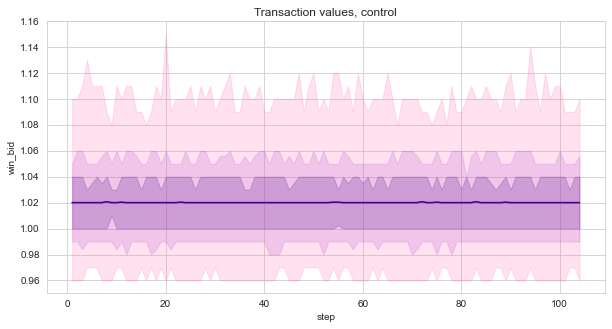

In [87]:
fig, ax = plt.subplots(figsize=(10,5))
for pct, col in zip([100, 80, 50], ['hotpink','mediumorchid','indigo']):
    sns.lineplot(control_df, ax=ax, x='step', y='win_bid', color=col, errorbar=('pi',pct))

plt.yticks(np.arange(96, 117, 2) / 100)
plt.title("Transaction values, control")
plt.savefig("data_model_outputs/plots_stats/control_wb", dpi=300)

In [81]:
for n in [100, 80, 50]:
    print(n)

100
80
50


<AxesSubplot:xlabel='step', ylabel='h_value'>

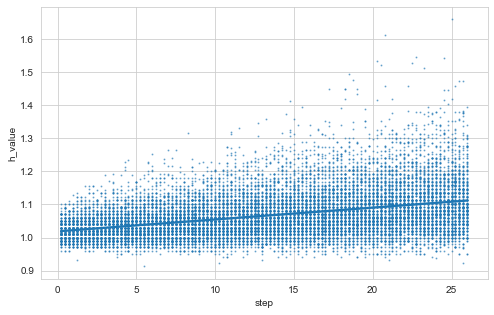

In [69]:

fig, ax = plt.subplots(figsize=(8,5))
sns.regplot(data=plotty, x='step', y='h_value', scatter_kws={'s':1, 'alpha':0.5}, ax=ax)

In [70]:
hi = experiments_df[experiments_df.n_flds == 2]

In [71]:
# sns.relplot(data=df_winbid_0f,
#             y='skew', x='std', kind='scatter', size='step' , sizes=(80,10),)
# reverse order of size

In [72]:
# sns.relplot(data=df_hvalue_0f,
#             y='skew', x='std', kind='scatter', size='step', sizes=(80,10),)

In [73]:
# 2
# nd
# flood
# plots

# fig2, ax2 = plt.subplots(figsize=(10,6))
# fg2 = sns.FacetGrid(agg_t_post2F_flood, col='category', hue=yr_new_name, palette=cmap_t2r,
#                     legend_out=True, aspect=0.8)
# fg2.map_dataframe(sns.lineplot, x='step', y='mean')
# fg2.figure.suptitle("Mean of winning bids in flooded areas, after 2nd flood")
# fg2.set_xlabels('Year')
# fg2.set_ylabels('Winning bid [-]')
# fg2.set_titles(col_template="Flooded: {col_name}")
# fg2.add_legend()
# fg2.set(xticks=[time_range[0], 0, 4, time_range[1]])
# fg2.tight_layout()
# fg2.savefig('data_model_outputs/plots_stats/wb_mean_win_bids_post2ndF_flooded.jpg', dpi=600)
#
# # fig2, ax2 = plt.subplots(figsize=(10,6))
# fg3 = sns.FacetGrid(agg_p_post2F_noflood, col='category', hue=yr_new_name, palette=cmap_t2r,
#                     legend_out=True, height=5.5, aspect=0.35)
# fg3.map_dataframe(sns.scatterplot, x='step', y='mean', size='skew')
# fg3.figure.suptitle("House prices in unflooded areas (skew), after 2nd flood")
# fg3.set_xlabels('Year')
# fg3.set_ylabels('Winning bid [-]')
# fg3.set_titles(col_template="{col_name}")
# fg3.add_legend()
# fg3.set(xticks=[time_range[0], 0, 4, time_range[1]])
# fg3.tight_layout()
# # fg3.savefig('data_model_outputs/plots_stats/hv_mean_prices_post2ndF_unflooded_skew.jpg', dpi=600)
# fg4 = sns.FacetGrid(agg_p_post2F_noflood, col='category', hue=yr_new_name, palette=cmap_t2r,
#                     legend_out=True, height=5.5, aspect=0.35, sharey=True)
# fg4.map_dataframe(sns.lineplot, x='step', y='mean')
# fg4.figure.suptitle("Median of house prices in unflooded areas, after 2nd flood")
# fg4.set_xlabels('Year')
# fg4.set_ylabels('House price[-]')
# fg4.set_titles(col_template="{col_name}")
# fg4.add_legend()
# fg4.set(xticks=[time_range[0], 0, 4, time_range[1]])
# fg4.tight_layout()
# # fg4.savefig('data_model_outputs/plots_stats/median_prices_post2ndF_flooded.jpg', dpi=600)
# # fg5 = sns.FacetGrid(agg_p_post2F_noflood, col='category', hue=yr_new_name, palette=cmap_t2r,legend_out=True, height=3, aspect=1, col_wrap=2, sharey=True)
# fg5 = sns.relplot(data=agg_p_post2F_noflood, col='category', hue=yr_new_name, palette=cmap_t2r, col_wrap=2, height=3,
#                   aspect=1.2, hue_order=select_2fs_years[::-1], size='step', y='skew', x='iqr_80', kind='scatter')
#
# # fg5.map_dataframe(sns.scatterplot, x='iqr_80', y='skew', size='step')
# fg5.figure.suptitle("Interdecile range vs skewness of house prices, after 2nd flood")
# fg5.set_xlabels('Interdecile range [-]')
# fg5.set_ylabels('Skewness [-]')
# fg5.set_titles(col_template="{col_name}")
# fg5.tight_layout()
# fg5.add_legend()
# # fg5.set(xticks=[time_range[0], 0, 4, time_range[1]])

# fg5.savefig('data_model_outputs/plots_stats/hv_iqr_vs_skew_post2ndF_unflooded.jpg', dpi=600)

In [74]:
# collect key metrics for bulk-level results
# categories, timing = t_describe_hvalue.index.levels # extract categories and timing from multiindex
# assumption: the categories and timing are consistent between t_describe and p_describe

# use the h_value column from the transactions data, instead of the general price indices data
# p_describe_group = t_describe_hvalue.groupby(level=['category'])
# p_skew_max =  p_describe_group['skew'].max()
# p_skew_min = p_describe_group['skew'].min()
# p_skew_max_t = p_describe_group['skew'].idxmax().str[1]
# p_skew_min_t = p_describe_group['skew'].idxmin().str[1]
# p_skew_end = p_describe.loc[(categories, timing[-1]), 'skew']
#
# p_median_max =
# p_counts = p_describe
# p_dict = {
#
#     'skew_idx': p_describe_group['skew'].idxmax
# }
# t_dict = {}



In [75]:
# cold storage for prices

# # repeat for the prices df for the slice
# all_p_df =pd.concat([pd.read_pickle(f'{save_dir}/{path}') for path in subset['A']], keys=scen_name, names=['scenario']).reset_index()
# all_p_df['step'] = (all_p_df['step'].astype(int) // 4).astype('category')
# p_group = all_p_df.groupby(['category', 'step'])
#
# p_describe = p_group['h_value'].describe(percentiles=[.1, .25, .5, .75, .9])
# # p_describe.index.rename(level=1, names='stats', inplace=True)
# p_describe['med_abs_dev'] = p_group['h_value'].agg(stats.median_abs_deviation, **{'nan_policy': 'omit'})
# p_describe[['dev_10%', 'dev_25%', 'dev_75%', 'dev_90%']] = p_describe[['10%', '25%', '75%', '90%']].sub(p_describe['50%'], axis='index').abs()
# p_describe['skew'] = p_group['h_value'].agg(stats.skew)

In [76]:

# cast into df with rows of categories
# isolate into steps of 5 years.... (maybe use bin again?)
# if steps is higher than 5/2, then make new bin
# get 95% bounds for all transactions and median
# probably make a heat-map
# make transpose everything into t= columns
# maybe use pivot or groupby to cast the categories into index
#


# fg = sns.FacetGrid(all_transactions_df, row='category', col='scenario',legend_out=True)
# fg.map(sns.lineplot, 'step','win_bid', **{'errorbar':('pi',100)})
# # outcome: plot facet-grid?
# plt.tight_layout()
# plt.savefig(f'{save_dir}/trial_outputs/big_boi_facet.jpg', dpi=1000)

In [77]:

# # look at winbid, for medians higher than 50%
# # group for proportions higher than 1.0
# t_dwb_high_medians_gb = t_describe_winbid[t_describe_winbid['50%'] >= 1.0].drop(columns=['count','med_abs_dev']).groupby(['category'])
# # make list for concat
# t_dwb_high_medians_list = []
# t_dwb_high_medians_list.append(t_dwb_high_medians_gb['50%'].agg([pd.Series.count, pd.Series.mean, pd.Series.median, pd.Series.max]))
# t_dwb_high_medians_list.append(t_dwb_high_medians_gb['skew'].agg([pd.Series.mean, pd.Series.max, stats.skew]))
#
# t_dwb_high_medians = pd.concat(t_dwb_high_medians_list, axis=1)
# t_dwb_high_medians['count'] = (t_dwb_high_medians['count'] / t_dwb_high_medians.loc['Unflooded, safe', 'count']).round(decimals=1)
# t_dwb_high_medians.columns = ["proportion_sim", 'mean_median','median_median','max_median','mean_skew','max_skew','skew_skew']
#
#
# if len(timing) == 2:
#     t_dwb_high_medians['timing_2f'] = timing[1]
#     agg_t_median_2f_list.append(t_dwb_high_medians)
#
# elif len(timing) == 1:
#     agg_t_median_1f = t_dwb_high_medians
# elif len(timing) == 0:
#     agg_t_median_0f = t_dwb_high_medians
#
# else:
#     raise ValueError(f"Timing is invalid: {timing}")


In [78]:
    # t_describe.index.rename(level=1, names='stats', inplace=True)
# get median absolute deviation
# t_describe_winbid['med_abs_dev'] = t_group[focus_col].agg(stats.median_abs_deviation)
# try: get the difference between median and boundaries
# t_describe_winbid.drop(columns = ['std'], inplace=True)
# t_describe_winbid[['dev_10%', 'dev_25%', 'dev_75%', 'dev_90%']] = t_describe_winbid[['10%', '25%', '75%', '90%']].sub(t_describe_winbid['50%'], axis='index').abs() #- test2['50%']


# t_describe.index.rename(level=1, names='stats', inplace=True)
# get median absolute deviation
# t_describe_hvalue['med_abs_dev'] = t_group[focus_col].agg(stats.median_abs_deviation)
# try: get the difference between median and boundaries
# t_describe_hvalue[['dev_10%', 'dev_25%', 'dev_75%', 'dev_90%']] = t_describe_hvalue[['10%', '25%', '75%', '90%']].sub(t_describe_hvalue['50%'], axis='index').abs() #- test2['50%']
# get the skew of the year cross-section